In [1]:
import numpy as np
import pandas as pd
import datetime
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

import matplotlib.pyplot as plt
%matplotlib inline

import sys, os, gc, types
import time
from subprocess import check_output

In [2]:
root_paths = [
    "/data/kaggle-wikipedia/data2/",
    "/home/you/repos/Wikipedia/data2/",
    "/Users/jiayou/Dropbox/JuanCode/Kaggle/Wikipedia/data2/",
    "/Users/jiayou/Dropbox/Documents/JuanCode/Kaggle/Wikipedia/data2/"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break

In [3]:
lgb = pd.read_csv(root + 'test_prediction.gb15-17-stack.csv')
rnn = pd.read_csv(root + 'test_prediction.nn21.csv')

In [6]:
ensemble = lgb.copy()
ensemble.Visits = (lgb.Visits + rnn.Visits)/2

In [10]:
ensemble.to_csv(os.path.join(root, 'test_prediction.ensemble.csv'), index=None)

In [11]:
ensemble_r = lgb.copy()
ensemble_r.Visits = np.round((lgb.Visits.values + rnn.Visits.values)/2)

In [12]:
ensemble_r.to_csv(os.path.join(root, 'test_prediction.ensemble_round.csv'), index=None)

In [13]:
ensemble_r.head()

,Id,Visits
0,0b293039387a,444.0
1,7114389dd824,440.0
2,057b02ff1f09,452.0
3,bd2aca21caa3,531.0
4,c0effb42cdd5,541.0


In [3]:
ans = {}
ans[0] = pd.read_csv(root + 'solution_09_22.csv')
ans[1] = pd.read_csv(root + 'solution_10_03.csv')
ans[2] = pd.read_csv(root + 'solution_10_07.csv')
ans[3] = pd.read_csv(root + 'solution_10_18.csv')
ans[4] = pd.read_csv(root + 'solution_10_25.csv')
ans[5] = pd.read_csv(root + 'solution_11_01.csv')

In [5]:
lgb_15 = pd.read_csv(root + 'test_prediction.gb15-ensemble.csv')

In [6]:
key = pd.read_pickle(root + 'key_2_modified.pkl')

In [7]:
key.head()

,Page,Id,date
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17


In [8]:
for k in ans.keys():
    ans[k] = ans[k].merge(key[['Id', 'date']], on='Id', how='left')

In [9]:
ans[0].head()

,Id,Visits,Usage,date
0,0b293039387a,313.0,Public,2017-09-13
1,7114389dd824,297.0,Public,2017-09-14
2,057b02ff1f09,354.0,Public,2017-09-15
3,bd2aca21caa3,420.0,Public,2017-09-16
4,c0effb42cdd5,575.0,Public,2017-09-17


In [10]:
ans[0].groupby('date').Visits.mean().head(10)

date
2017-09-13    1001.160296
2017-09-14     977.661099
2017-09-15     924.136175
2017-09-16     956.054824
2017-09-17    1052.197631
2017-09-18    1119.110793
2017-09-19     663.794083
2017-09-20       0.000000
2017-09-21       0.000000
2017-09-22       0.000000
Name: Visits, dtype: float64

7
20
24
35
39
48


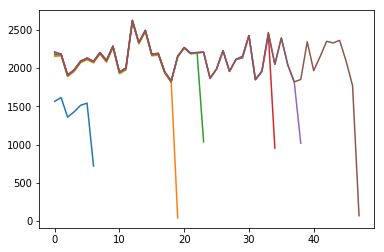

In [11]:
for i in ans.keys():
    y = ans[i][(ans[i].Visits == 0).values & (ans[i].Usage == 'Public').values].groupby('date').Visits.count().values
    plt.plot(
        y,
    )
    print(len(y))

In [12]:
ans = ans[5]

In [13]:
ans.Usage.value_counts()

Public     6662988
Ignored    2330918
Name: Usage, dtype: int64

In [14]:
ans['lgb'] = lgb.Visits
ans['rnn'] = rnn.Visits
ans['lgb_15'] = lgb_15.Visits

In [15]:
ans['lgb_SMAPE'] = 200 * np.abs(ans.Visits.values - ans.lgb.values) / np.maximum(1e-6, (ans.Visits.values + ans.lgb.values))
ans['rnn_SMAPE'] = 200 * np.abs(ans.Visits.values - ans.rnn.values) / np.maximum(1e-6, (ans.Visits.values + ans.rnn.values))
ans['lgb_15_SMAPE'] = 200 * np.abs(ans.Visits.values - ans.lgb_15.values) / np.maximum(1e-6, (ans.Visits.values + ans.lgb_15.values))

In [16]:
ans.head()

,Id,Visits,Usage,date,lgb,rnn,lgb_15,lgb_SMAPE,rnn_SMAPE,lgb_15_SMAPE
0,0b293039387a,313.0,Public,2017-09-13,456.0,432.0,456.0,37.191157,31.946309,37.191157
1,7114389dd824,297.0,Public,2017-09-14,456.0,424.0,456.0,42.231076,35.228849,42.231076
2,057b02ff1f09,354.0,Public,2017-09-15,461.0,443.0,461.0,26.257669,22.333752,26.257669
3,bd2aca21caa3,420.0,Public,2017-09-16,535.0,527.0,535.0,24.083770,22.597677,24.083770
4,c0effb42cdd5,575.0,Public,2017-09-17,567.0,515.0,567.0,1.401051,11.009174,1.401051


In [17]:
ans = ans[ans.Usage == 'Public']

In [18]:
ans.shape

(6662988, 10)

In [19]:
ans.lgb_SMAPE.mean()

38.031884667754056

In [20]:
ans.rnn_SMAPE.mean()

37.940503645343348

In [21]:
ans['ens'] = (ans.lgb + ans.rnn) / 2
ans['ens_SMAPE'] = 200 * np.abs(ans.Visits.values - ans.ens.values) / np.maximum(1e-6, (ans.Visits.values + ans.ens.values))

In [22]:
ans.head()

,Id,Visits,Usage,date,lgb,rnn,lgb_15,lgb_SMAPE,rnn_SMAPE,lgb_15_SMAPE,ens,ens_SMAPE
0,0b293039387a,313.0,Public,2017-09-13,456.0,432.0,456.0,37.191157,31.946309,37.191157,444.0,34.610304
1,7114389dd824,297.0,Public,2017-09-14,456.0,424.0,456.0,42.231076,35.228849,42.231076,440.0,38.805970
2,057b02ff1f09,354.0,Public,2017-09-15,461.0,443.0,461.0,26.257669,22.333752,26.257669,452.0,24.317618
3,bd2aca21caa3,420.0,Public,2017-09-16,535.0,527.0,535.0,24.083770,22.597677,24.083770,531.0,23.343849
4,c0effb42cdd5,575.0,Public,2017-09-17,567.0,515.0,567.0,1.401051,11.009174,1.401051,541.0,6.093190


In [23]:
ans.ens_SMAPE.mean()

37.132590472450751

In [24]:
ans.lgb_15_SMAPE.mean()

38.184283277493044

In [40]:
(ans.Visits == 0).sum()

73634

In [44]:
(ans.lgb == 0).sum()

37252

In [45]:
(ans.rnn == 0).sum()

50577

In [25]:
ans_non0 = ans[ans.Visits != 0]

In [26]:
ans_non0.lgb_SMAPE.mean()

35.61501660506018

In [27]:
ans_non0.rnn_SMAPE.mean()

35.68123562771452

In [79]:
ans.head()

,Id,Visits,Usage,lgb,rnn,lgb_15,lgb_SMAPE,rnn_SMAPE,lgb_15_SMAPE,ens,ens_SMAPE,date
0,0b293039387a,313.0,Public,456.0,432.0,456.0,37.191157,31.946309,37.191157,444.0,34.610304,2017-09-13
1,7114389dd824,297.0,Public,456.0,424.0,456.0,42.231076,35.228849,42.231076,440.0,38.805970,2017-09-14
2,057b02ff1f09,354.0,Public,461.0,443.0,461.0,26.257669,22.333752,26.257669,452.0,24.317618,2017-09-15
3,bd2aca21caa3,420.0,Public,535.0,527.0,535.0,24.083770,22.597677,24.083770,531.0,23.343849,2017-09-16
4,c0effb42cdd5,575.0,Public,567.0,515.0,567.0,1.401051,11.009174,1.401051,541.0,6.093190,2017-09-17


In [28]:
ans_lb1 = ans_non0[ans_non0.date <= '2017-09-22']

In [29]:
ans_lb1.ens_SMAPE.mean()

31.419462227010104

In [30]:
ans_lb1.lgb_SMAPE.mean()

32.14540774240888

In [31]:
ans_lb1.rnn_SMAPE.mean()

32.40843680573398

In [58]:
ans_lb2 = ans[ans.date < '2017-10-03']

In [59]:
ans_lb2.lgb_SMAPE.mean()

35.45502070257997

In [60]:
ans_lb2.rnn_SMAPE.mean()

35.40888534973589

In [61]:
ans_lb3 = ans[ans.date < '2017-10-07']

In [47]:
ans.head()

,Id,Visits,Usage,date,lgb,rnn,lgb_15,lgb_SMAPE,rnn_SMAPE,lgb_15_SMAPE,ens,ens_SMAPE
0,0b293039387a,313.0,Public,2017-09-13,456.0,432.0,456.0,37.191157,31.946309,37.191157,444.0,34.610304
1,7114389dd824,297.0,Public,2017-09-14,456.0,424.0,456.0,42.231076,35.228849,42.231076,440.0,38.805970
2,057b02ff1f09,354.0,Public,2017-09-15,461.0,443.0,461.0,26.257669,22.333752,26.257669,452.0,24.317618
3,bd2aca21caa3,420.0,Public,2017-09-16,535.0,527.0,535.0,24.083770,22.597677,24.083770,531.0,23.343849
4,c0effb42cdd5,575.0,Public,2017-09-17,567.0,515.0,567.0,1.401051,11.009174,1.401051,541.0,6.093190


In [62]:
ans_lb3.lgb_SMAPE.mean()

36.020313357949

In [63]:
ans_lb3.rnn_SMAPE.mean()

35.936533204018765

In [51]:
ans_lb3 = ans[ans.date <= '2017-10-18']

In [52]:
ans_lb3.rnn_SMAPE.mean()

37.08223054747814

In [3]:
lb = []
for i in range(1,6):
    lb.append(pd.read_csv(root + '../Leaderboard/lb{}.csv'.format(i)))

In [4]:
lb[1].head()

,TeamId,TeamName,SubmissionDate,Score
0,791000,Jiaxinglin420,2017-09-07 05:33:09,47.85
1,797837,EJD,2017-09-07 18:05:45,39.52
2,788398,Gladiators,2017-09-07 19:48:50,55.69
3,805894,daten-kieker,2017-09-07 21:10:01,39.62
4,801225,neongen,2017-09-07 23:15:20,53.68


In [8]:
s = pd.DataFrame({'TeamName':lb[0].TeamName.unique()})
for i in range(5):
    s = s.merge(
        lb[i].groupby('TeamName').Score.agg({'lb{}'.format(i): 'last'}).reset_index(),
        on='TeamName',
        how='left',
    )

/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [9]:
s.head()

,TeamName,lb0,lb1,lb2,lb3,lb4
0,Jiaxinglin420,46.2,47.85,48.27,48.92,49.09
1,EJD,37.8,39.52,39.96,40.73,40.90
2,Gladiators,37.9,39.62,40.13,40.89,41.06
3,daten-kieker,37.9,39.62,40.12,40.90,41.07
4,neongen,52.9,53.68,53.79,53.75,53.68


In [10]:
s.sort_values(by='lb4', inplace=True, axis=0)

In [11]:
s.head(25)

,TeamName,lb0,lb1,lb2,lb3,lb4
366,Arthur Suilin,29.2,32.17,32.75,33.96,34.23
236,Chun Ming Lee,29.7,32.92,33.60,35.02,35.33
237,WTF,30.9,33.48,34.00,35.22,35.49
261,thousandvoices,30.8,33.84,34.36,35.54,35.79
210,SC,31.1,34.03,34.65,35.87,36.17
354,Nathaniel Maddux,31.9,34.49,35.00,35.96,36.17
356,sjv,31.1,34.22,34.77,35.94,36.17
376,Herra Huu,31.9,34.45,34.91,35.89,36.19
255,RoseKnights401,31.1,34.05,34.70,36.02,36.36
238,Stefan Stefanov,31.3,34.42,35.05,36.22,36.45


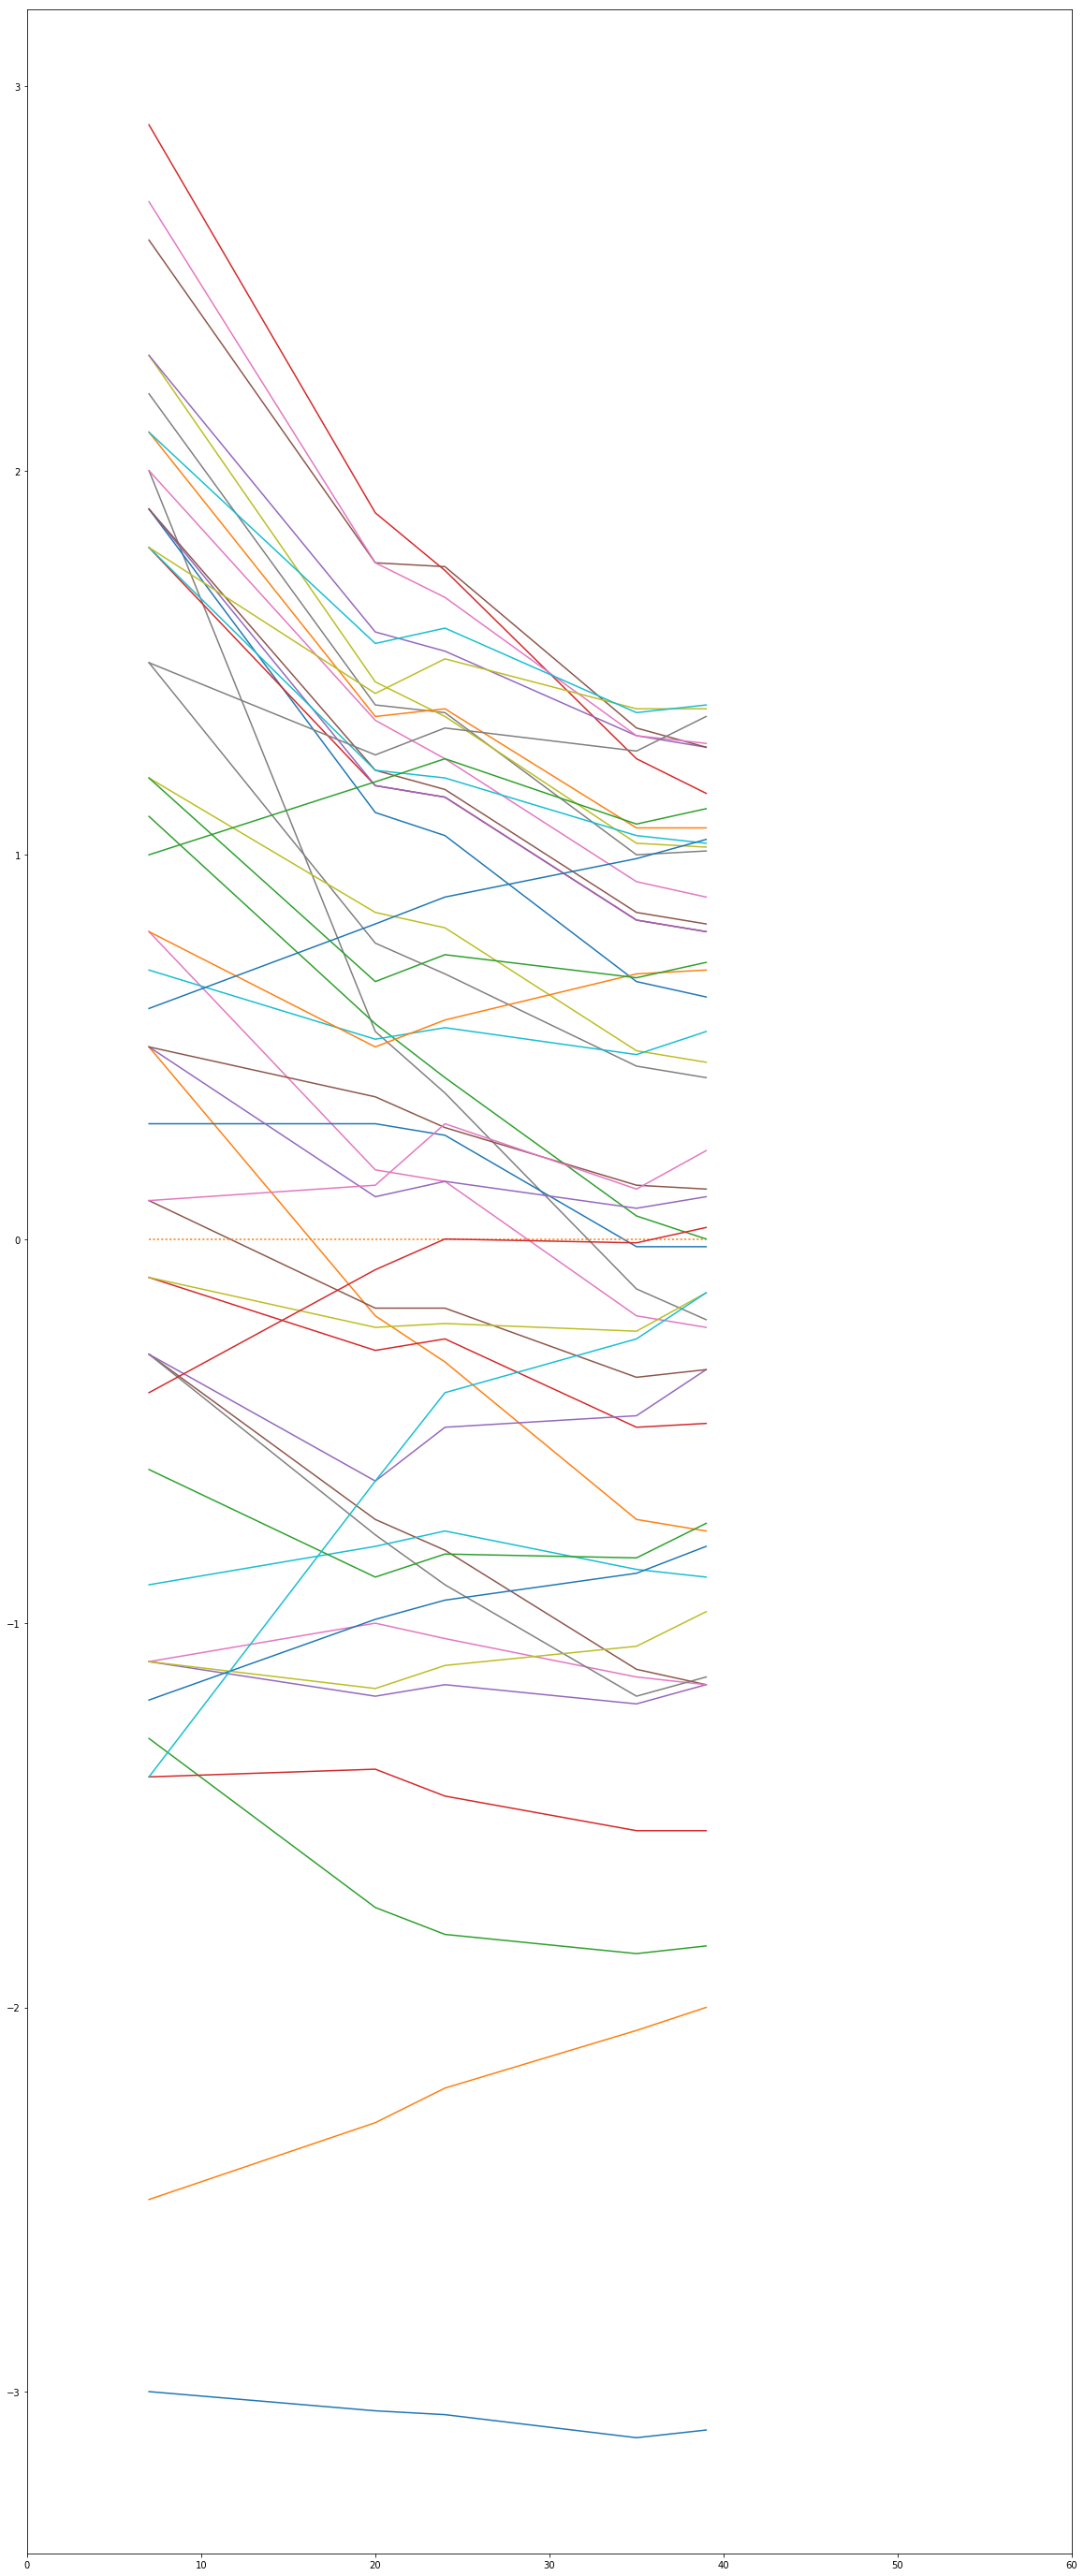

In [19]:
plt.figure(figsize=(20, 50))
plt.xlim(0, 60)
x = [7, 20, 24, 35, 39]
for i in range(50):
    if s.iloc[i,0] == 'Juan Zhai 卷宅':
        plt.plot(x, s.iloc[i,1:].values - s.iloc[21,1:].values, ':')
    else:
        plt.plot(x, s.iloc[i,1:].values - s.iloc[21,1:].values)
plt.show()